# Exploring the Dataset

In this section, I'll be doing some inital exploration of the MRI scans dataset.

### Imports

In [21]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


### Importing the training and testing data

In [ ]:
glioma_test_path = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\dst-project-2\MarkM\Data\testing\glioma"
meningioma_test_path = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\dst-project-2\MarkM\Data\Testing\meningioma"
notumor_test_path = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\dst-project-2\MarkM\Data\Testing\notumor"
pituitary_test_path = r"c:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\dst-project-2\MarkM\Data\Testing\pituitary"

In [15]:
glioma_train_path = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\dst-project-2\MarkM\Data\Training\glioma"
meningioma_train_path = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\dst-project-2\MarkM\Data\Training\meningioma"
notumor_train_path = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\dst-project-2\MarkM\Data\Training\notumor"
pituitary_train_path = r"c:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\dst-project-2\MarkM\Data\Training\pituitary"

Loaded 405 images.


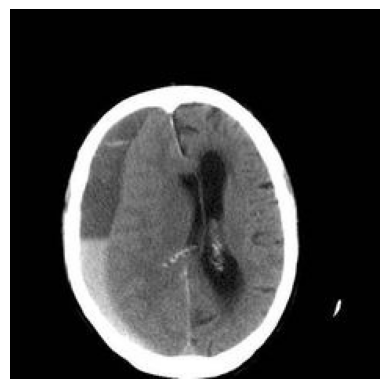

In [ ]:
folder_path = notumor_test_path  

# List to hold all loaded images
images = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        # Open and load the image
        img = Image.open(file_path)
        # Append the image object to the list
        images.append(img)

# Now `images` contains all opened jpg images from the folder
print(f"Loaded {len(images)} images.")

# Display the first image in the Jupyter Notebook
if images:  # Check if the list is not empty
    plt.imshow(images[0])  # Display the first image
    plt.axis('off')  # Hide axis for a cleaner look
    plt.show()


### Training a basic model

First, let's set up a basic CNN model suitable for image classification. This model will use convolutional layers to learn features from images and a final dense layer for classification into the 4 classes. I just said epochs=1 to speed up the NN.

In [33]:
# Paths to the directories containing images
train_dir = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\dst-project-2\MarkM\Data\Training"
test_dir = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\dst-project-2\MarkM\Data\Testing"

# Parameters
img_height, img_width = 128, 128  # Resize images for faster training
batch_size = 32
num_classes = 4  # glioma, meningioma, notumor, pituitary

# Image data generators for training and testing with basic augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the training data for validation
)

# Create generators for training and validation
print('TRAINING DATA')
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)
print('VALIDATION DATA')
validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

# Image data generator for test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load test images
print('TESTING DATA')
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test data
)

# Define and compile your model
def create_model(input_shape=(img_height, img_width, 3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(num_classes, activation='softmax')  # Output layer for 4 classes
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and train the model
model = create_model()
epochs = 2
history = model.fit(train_data,epochs=epochs,validation_data=validation_data)  # Use separate validation data)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# batch number = 179


TRAINING DATA
Found 4571 images belonging to 4 classes.
VALIDATION DATA
Found 1141 images belonging to 4 classes.
TESTING DATA
Found 1311 images belonging to 4 classes.
Epoch 1/2
143/143 [==============================] - 107s 747ms/step - loss: 1.0480 - accuracy: 0.5113 - val_loss: 0.9996 - val_accuracy: 0.6275
Epoch 2/2
41/41 [==============================] - 9s 218ms/step - loss: 1.1414 - accuracy: 0.5942
Test Loss: 1.1413761377334595, Test Accuracy: 0.5942028760910034


### Visualising our training

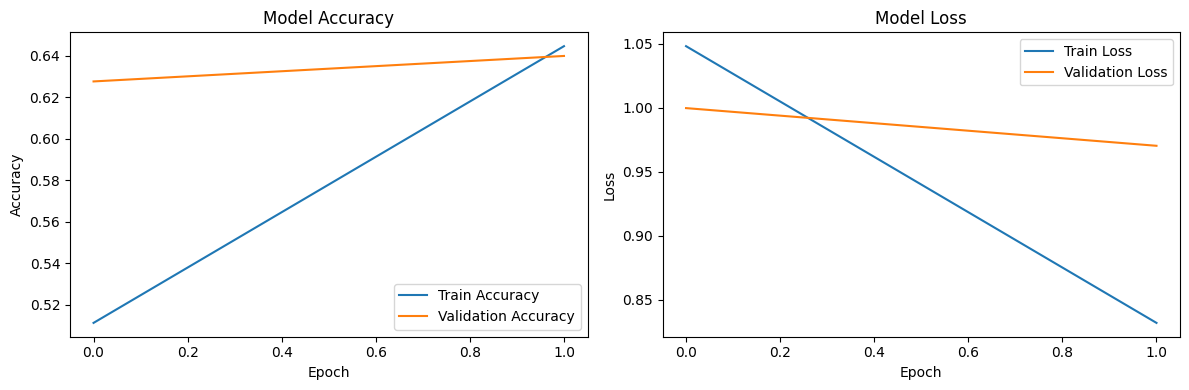

In [34]:
 #Visualization of training and validation metrics
def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_metrics(history)
